<a href="https://colab.research.google.com/github/Mahima-Bachhav/Siamese_Network/blob/main/Siamese_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

Helper Function

In [2]:
def imshow(img, text=None):
  npimg = img.numpy()
  plt.axis("off")
  if text:
    plt.text(75, 8, text, style='italic', fontweight = 'bold', bbox={'facecolor':'white', 'alpha':0.8, 'pad':10} )
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

def show_plot(iteration, loss):
  plt.plot(iteration, loss)
  plt.show()


In [3]:
!wget https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip
!rm -rf data
!unzip "at&t.zip" -d .

--2024-12-06 19:29:46--  https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/maticvl/dataHacker/master/DATA/at%26t.zip [following]
--2024-12-06 19:29:47--  https://raw.githubusercontent.com/maticvl/dataHacker/master/DATA/at%26t.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3797060 (3.6M) [application/zip]
Saving to: ‘at&t.zip.2’

at&t.zip.2          100%[===================>]   3.62M  --.-KB/s    in 0.05s   

2024-12-06 19:29:47 (69.4 MB/s) - ‘at&t.zip.2’ saved [3797060/3797060]

Archive:  at&t.zip
   creating: ./data/
   creatin

In [4]:
class SiameseNetworkDataset(Dataset):
  def __init__(self, imageFolderDataset, transform=None):
    self.imageFolderDataset = imageFolderDataset
    self.transform = transform

  def __getitem__(self,index):
    img0_tuple = random.choice(self.imageFolderDataset.imgs)

    same_class = random.randint(0,1)
    if same_class:
      while True:
        img1_tuple = random.choice(self.imageFolderDataset.imgs)
        if img0_tuple[1] == img1_tuple[1]:
          break

    else:

      while True:
        img1_tuple = random.choice(self.imageFolderDataset.imgs)
        if img0_tuple[1] != img1_tuple[1]:
          break

    img0 = Image.open(img0_tuple[0])
    img1 = Image.open(img1_tuple[0])

    img0 = img0.convert("L")
    img1 = img1.convert("L")

    if self.transform is not None:
      img0 = self.transform(img0)
      img1 = self.transform(img1)

    return img0, img1, torch.from_numpy(np.array([int(img1_tuple != img0_tuple[1])], dtype=np.float32))

  def __len__(self):
    return len(self.imageFolderDataset.imgs)



In [5]:
folder_dataset = datasets.ImageFolder(root="./data/faces/training")

In [6]:
transformation = transforms.Compose([transforms.Resize((100,100)), transforms.ToTensor()])

siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset, transform = transformation)

In [7]:
class SiameseNetwork(nn.Module):
  def __init__(self):
    super(SiameseNetwork, self).__init__()
    self.cnn1 = nn.Sequential(
        nn.Conv2d(1,96,11,4),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(3,2),

        nn.Conv2d(96,256,5,1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2,2),

        nn.Conv2d(256,384,3,1),
        nn.ReLU(inplace=True)
    )

    self.fc1 = nn.Sequential(
        nn.Linear(384, 1024),
        nn.ReLU(inplace=True),

        nn.Linear(1024, 256),
        nn.ReLU(inplace=True),

        nn.Linear(256, 2)
    )

  def forward_once(self, x):
    output = self.cnn1(x)
    output = output.view(output.size()[0], -1)
    output = self.fc1(output)
    return output

  def forward(self, input1, input2):
    output1 = self.forward_once(input1)
    output2 = self.forward_once(input2)
    return output1,output2

In [22]:
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256,2)
        )

    def forward_once(self, x):
        # This function will be called for both images
        # It's output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [8]:
class ContrastiveLoss(torch.nn.Module):
  def __init__(self, margin=2.0):
    super(ContrastiveLoss, self).__init__()
    self.margin = margin

  def forward(self, output1, output2, label):
    euclidean_distance = F.pairwise_distance(output1,output2, keepdims = True)

    loss_contrastive = torch.mean((1-label)+ torch.pow(euclidean_distance, 2)+ (label)*torch.pow(torch.clamp(self.margin - euclidean_distance, min = 0.0), 2))

    return loss_contrastive

In [9]:
train_dataloader = DataLoader(siamese_dataset, shuffle = True, num_workers=8, batch_size=64)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [10]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005)

Epoch number 0
 Current loss 3.99647855758667

Epoch number 1
 Current loss 3.3099193572998047

Epoch number 2
 Current loss 3.0960488319396973

Epoch number 3
 Current loss 2.85750675201416

Epoch number 4
 Current loss 2.852518081665039

Epoch number 5
 Current loss 2.7988200187683105

Epoch number 6
 Current loss 2.7097387313842773

Epoch number 7
 Current loss 2.7858855724334717

Epoch number 8
 Current loss 2.7997825145721436

Epoch number 9
 Current loss 2.610158920288086

Epoch number 10
 Current loss 2.4564859867095947

Epoch number 11
 Current loss 2.684885263442993

Epoch number 12
 Current loss 2.5697379112243652

Epoch number 13
 Current loss 2.539602756500244

Epoch number 14
 Current loss 2.5594937801361084

Epoch number 15
 Current loss 2.5272974967956543

Epoch number 16
 Current loss 2.5295796394348145

Epoch number 17
 Current loss 2.557891845703125

Epoch number 18
 Current loss 2.5104379653930664

Epoch number 19
 Current loss 2.539391040802002

Epoch number 20
 Cur

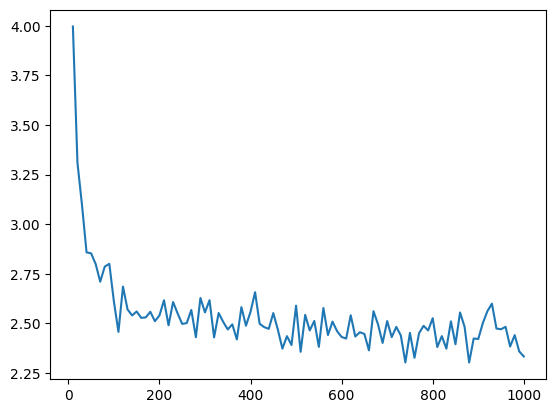

In [11]:
counter = []
loss_history = []
iteration_number= 0

# Iterate throught the epochs
for epoch in range(100):

    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)


In [21]:
def train_siamese_network(net, train_dataloader, criterion, optimizer, num_epochs=100, log_interval=10):

    counter = []
    loss_history = []
    iteration_number = 0

    for epoch in range(num_epochs):

        for i, (img0, img1, label) in enumerate(train_dataloader, 0):
            img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
            optimizer.zero_grad()
            output1, output2 = net(img0, img1)
            loss_contrastive = criterion(output1, output2, label)
            loss_contrastive.backward()
            optimizer.step()

            if i % log_interval == 0:
                print(f"Epoch {epoch}, Batch {i}, Loss: {loss_contrastive.item()}")
                iteration_number += log_interval
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())

    return counter, loss_history

Epoch 0, Batch 0, Loss: 2.4260149002075195
Epoch 1, Batch 0, Loss: 2.2855019569396973
Epoch 2, Batch 0, Loss: 2.437927484512329
Epoch 3, Batch 0, Loss: 2.4565846920013428
Epoch 4, Batch 0, Loss: 2.445972442626953
Epoch 5, Batch 0, Loss: 2.370605945587158
Epoch 6, Batch 0, Loss: 2.49428653717041
Epoch 7, Batch 0, Loss: 2.6122779846191406
Epoch 8, Batch 0, Loss: 2.3916842937469482
Epoch 9, Batch 0, Loss: 2.399458408355713
Epoch 10, Batch 0, Loss: 2.471308946609497
Epoch 11, Batch 0, Loss: 2.4532876014709473
Epoch 12, Batch 0, Loss: 2.4833321571350098
Epoch 13, Batch 0, Loss: 2.343656063079834
Epoch 14, Batch 0, Loss: 2.4358787536621094
Epoch 15, Batch 0, Loss: 2.511434555053711
Epoch 16, Batch 0, Loss: 2.5073294639587402
Epoch 17, Batch 0, Loss: 2.454012870788574
Epoch 18, Batch 0, Loss: 2.429795742034912
Epoch 19, Batch 0, Loss: 2.3926620483398438
Epoch 20, Batch 0, Loss: 2.3671936988830566
Epoch 21, Batch 0, Loss: 2.3969171047210693
Epoch 22, Batch 0, Loss: 2.419224500656128
Epoch 23, 

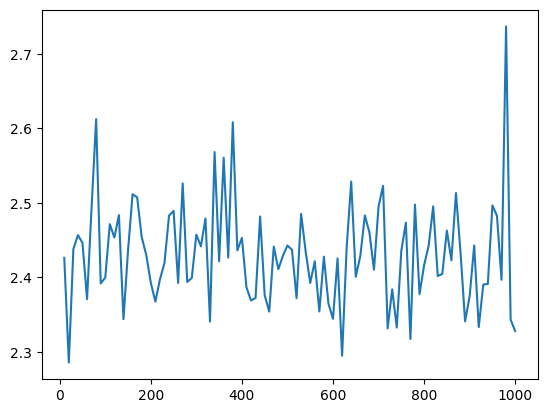

In [22]:
counter, loss_history = train_siamese_network(
    net=net,
    train_dataloader=train_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=100,
    log_interval=10
)

show_plot(counter, loss_history)

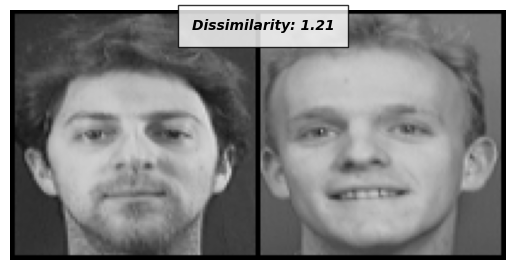

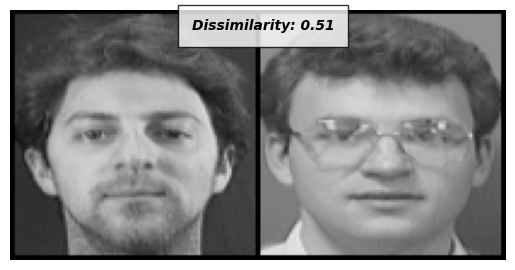

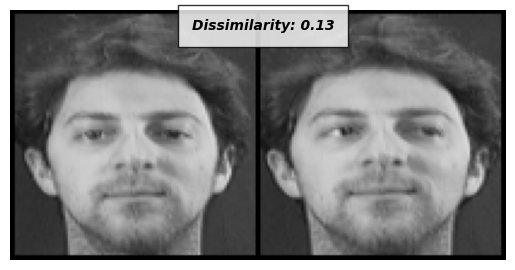

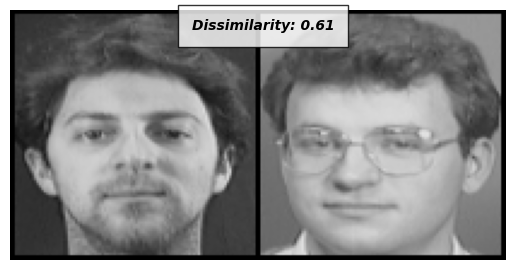

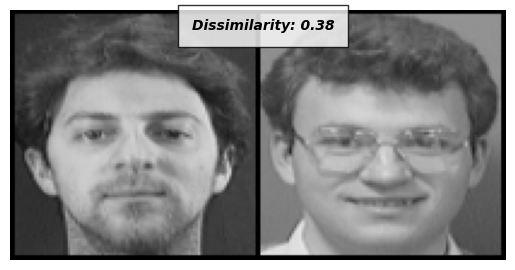

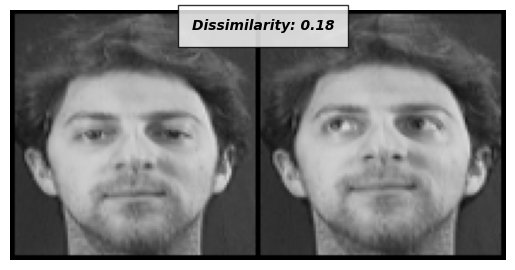

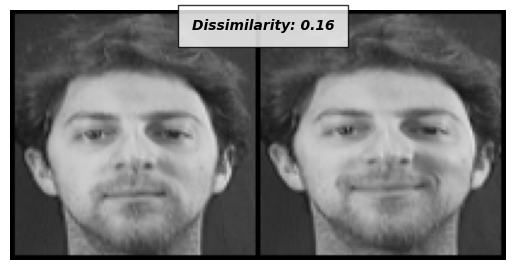

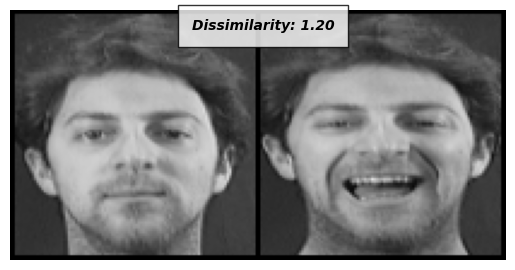

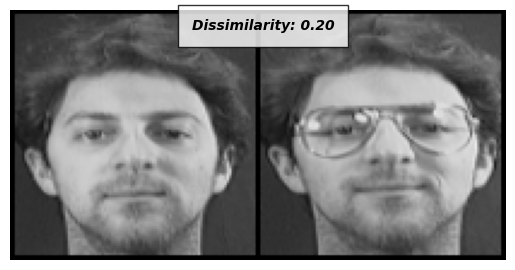

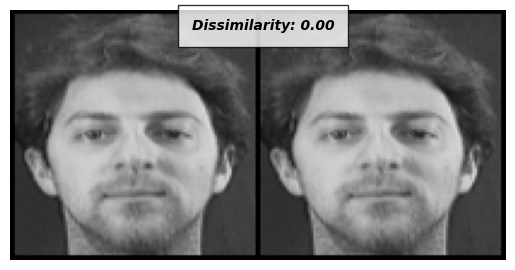

In [16]:
folder_dataset_test = datasets.ImageFolder(root="./data/faces/testing/")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

for i in range(10):
    # Iterate over 10 images and test them with the first image (x0)
    _, x1, label2 = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), 0)

    output1, output2 = net(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')

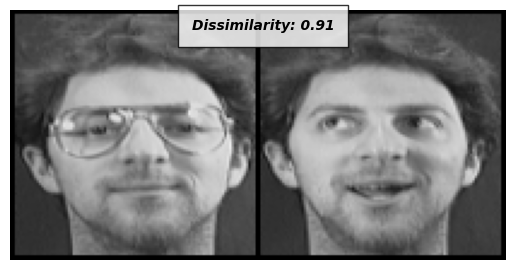

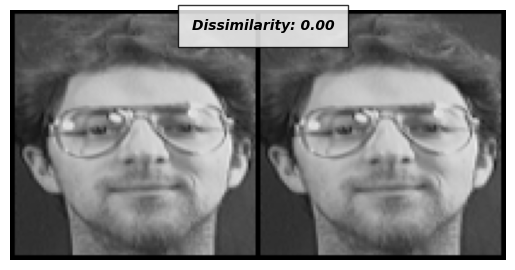

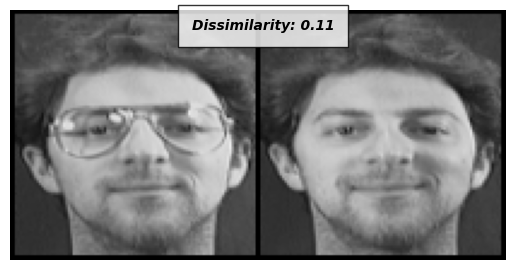

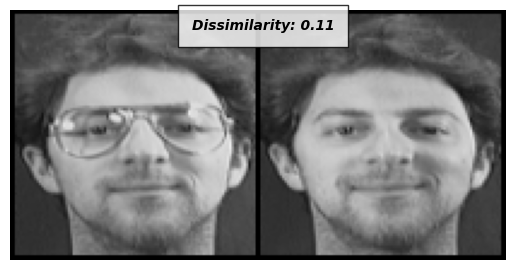

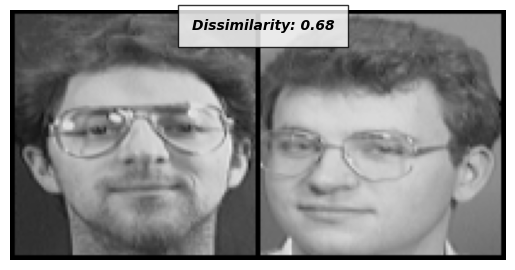

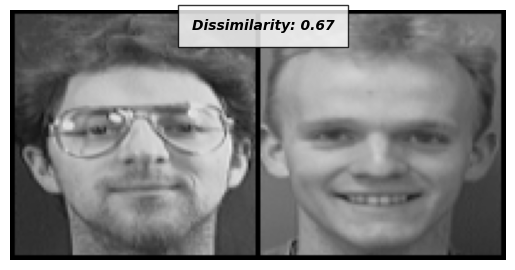

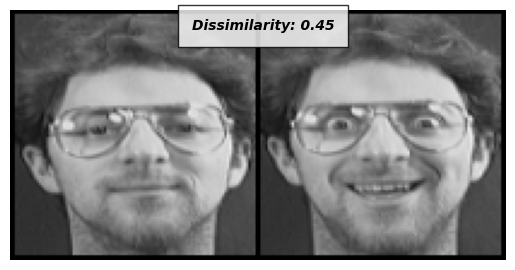

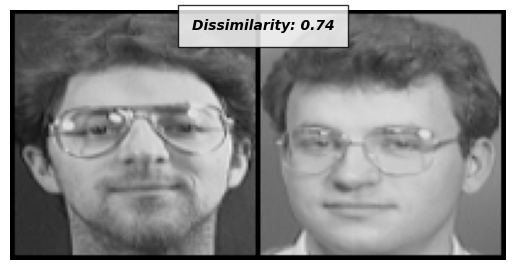

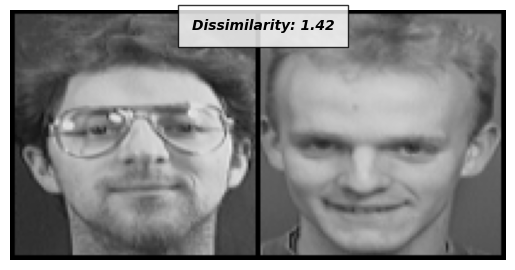

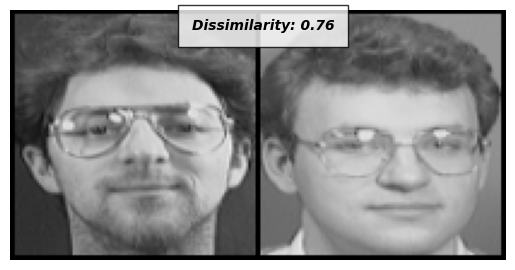

In [13]:
# Locate the test dataset and load it into the SiameseNetworkDataset
folder_dataset_test = datasets.ImageFolder(root="./data/faces/testing/")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

for i in range(10):
    # Iterate over 10 images and test them with the first image (x0)
    _, x1, label2 = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), 0)

    output1, output2 = net(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')